#### An example illustrating the approximation of the feature map of an RBF kernel.

It shows how to use `RBFSampler` and `Nystroem` to approximate the feature map of an `RBF kernel` for `classification` with an `SVM` on the digits dataset. Results using a `linear SVM` in the original space, a `linear SVM` using the approximate mappings and using a `kernelized SVM` are compared. `Timings` and `accuracy` for varying amounts of `Monte Carlo samplings` (in the case of `RBFSampler`, which uses `random Fourier features`) and different sized subsets of the training set (for `Nystroem`) for the approximate mapping are shown. 

In [1]:
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Letters Classification
Source: https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format

In [2]:
letters_data = pd.read_csv('datasets/A_Z Handwritten Data.csv', header=None)

letters_data.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183488,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58998,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210835,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195630,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
letters_data.shape

(372451, 785)

In [4]:
letters_data = letters_data.sample(frac=0.01).reset_index(drop=True)

letters_data.shape

(3725, 785)

In [5]:
sorted(letters_data[0].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

##### Creating lookup table

In [6]:
LOOKUP = { 0: 'A', 1: 'B', 2: 'C', 3: 'D', 
          4: 'E', 5: 'F', 6: 'G', 7: 'H', 
          8: 'I', 9: 'J',10: 'K', 11: 'L', 
          12: 'M', 13: 'N', 14: 'O', 15: 'P', 
          16: 'Q', 17: 'R', 18: 'S',19: 'T', 
          20: 'U', 21: 'V', 22: 'W', 23: 'X', 
          24: 'Y', 25: 'Z'}

#### Function for displaying letters

In [7]:
def display_image(features, actual_label):
    
    print("Actual label: ", LOOKUP[actual_label])
    
    plt.imshow(features.reshape(28, 28), cmap='Greys')
    
    plt.show()

In [8]:
X = letters_data[letters_data.columns[1:]]

Y = letters_data[0]

In [9]:
Y.loc[5]

16

In [10]:
X.loc[5].values[100:650]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  92,
       207, 243, 163,  68,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  34,  50, 156, 249, 152,   6,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  59, 244, 192,   3,  96, 253, 133,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  71, 212, 255, 173,   0,   0, 139, 247,  59,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 115, 253, 172, 119,   9,   0,   0,   3,
       230, 176,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 110, 251, 136,   7,   0,   0,   0,
         0,   0, 108, 253,  66,   0,   0,   0,   0,   0,   0,   

Actual label:  C


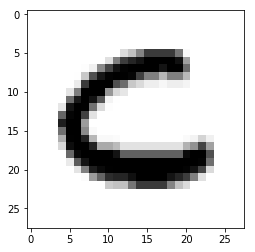

In [11]:
display_image(X.loc[345].values, Y.loc[345])

Actual label:  Q


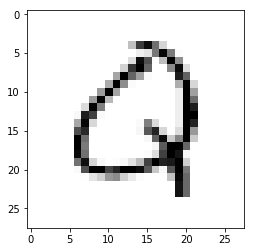

In [12]:
display_image(X.loc[5].values, Y.loc[5])

Actual label:  A


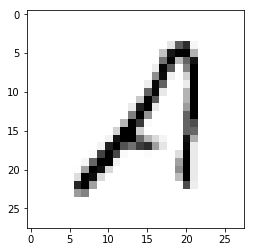

In [13]:
display_image(X.loc[550].values, Y.loc[550])

Actual label:  C


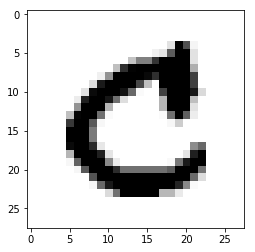

In [14]:
display_image(X.loc[3723].values, Y.loc[3723])

In [17]:
X = X / 255.  # Scale to be in the range of 0 to 1

X -= X.mean(axis=0)

In [19]:
X.loc[5].values[100:110]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
# X.loc[15].values[345:453]

In [22]:
n_samples = len(letters_data)
n_samples

3725

In [23]:
# We learn the digits on the first half of the digits
data_train, labels_train = (X[:n_samples // 2],
                            Y[:n_samples // 2])

In [24]:
# Now predict the value of the digit on the second half:
data_test, labels_test = (X[n_samples // 2:],
                          Y[n_samples // 2:])

In [25]:
data_train.shape, labels_train.shape

((1862, 784), (1862,))

In [26]:
data_test.shape, labels_test.shape

((1863, 784), (1863,))

In [29]:
# Import classifiers and performance metrics
from time import time
from sklearn import svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem

##### Initializing the classifier
we are initializing the linear SVC and SVC and creating a pipeline from kernel approximation and linear SVC

In [30]:
# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=0.01)

linear_svm = svm.LinearSVC()

In [31]:
# create pipeline from kernel approximation
# and linear svm
rbf_approx_svm = pipeline.Pipeline([
    ('rbf_sampler', RBFSampler(gamma=0.01, random_state=1)), 
    ('svm', svm.LinearSVC())
])

In [32]:
nystroem_approx_svm = pipeline.Pipeline([
    ('nystroem', Nystroem(gamma=0.01, random_state=1)),
    ('svm', svm.LinearSVC())
])

Measuring the accuracy and training time for SVC

In [33]:
# fit and predict using kernel svm:

start = time()

kernel_svm.fit(data_train, labels_train)
kernel_svm_score = kernel_svm.score(data_test, labels_test)

kernel_svm_time = time() - start

print('Score: ', kernel_svm_score)
print('Runtime: ', kernel_svm_time)

Score:  0.15083199141170156
Runtime:  8.402267694473267


Measuring the accuraccy and training time for Linear SVC 

In [34]:
# fit and predict using linear svm:

start = time()

linear_svm.fit(data_train, labels_train)
linear_svm_score = linear_svm.score(data_test, labels_test)

linear_svm_time = time() - start

print('Score: ', linear_svm_score)
print('Runtime: ', linear_svm_time)

Score:  0.27428878153515834
Runtime:  2.340487241744995


Changing the C value because model did not converge and again measuring the accuracy and training time

In [36]:
start = time()

linear_svm.set_params(C=0.1)
linear_svm.fit(data_train, labels_train)
linear_svm_score = linear_svm.score(data_test, labels_test)

linear_svm_time = time() - start

print('Score: ', linear_svm_score)
print('Runtime: ', linear_svm_time)

Score:  0.7557702630166399
Runtime:  1.3526630401611328


Measuring accuracy and training time for Linear SVC using RBFSampler kernel approx.

In [37]:
start = time()

rbf_approx_svm.set_params(rbf_sampler__n_components=len(data_train))
rbf_approx_svm.set_params(svm__C=0.1)

rbf_approx_svm.fit(data_train, labels_train)
rbf_approx_svm_score = rbf_approx_svm.score(data_test, labels_test)

rbf_approx_svm_time = time() - start

print('Score: ', rbf_approx_svm_score)
print('Runtime: ', rbf_approx_svm_time)

Score:  0.7439613526570048
Runtime:  3.0124878883361816


Measuring accuracy and training time for Linear SVC using Nystroem kernel approx.

In [38]:
start = time()

nystroem_approx_svm.set_params(nystroem__n_components=len(data_train))
nystroem_approx_svm.set_params(svm__C=0.1)

nystroem_approx_svm.fit(data_train, labels_train)
nystroem_approx_svm_score = nystroem_approx_svm.score(data_test, labels_test)

nystroem_approx_svm_time = time() - start

print('Score: ', nystroem_approx_svm_score)
print('Runtime: ', nystroem_approx_svm_time)

Score:  0.7498658078368223
Runtime:  7.749323844909668


Changing the C value and then again measuring accuracy and training time for Linear SVC using RBFSampler kernel approx. and Nystroem kernel approx. Now accuracy is increased.

In [39]:
start = time()

rbf_approx_svm.set_params(rbf_sampler__n_components=len(data_train))
rbf_approx_svm.set_params(svm__C=1)

rbf_approx_svm.fit(data_train, labels_train)
rbf_approx_svm_score = rbf_approx_svm.score(data_test, labels_test)

rbf_approx_svm_time = time() - start

print('Score: ', rbf_approx_svm_score)
print('Runtime: ', rbf_approx_svm_time)

Score:  0.8346752549651101
Runtime:  3.922372817993164


In [40]:
start = time()

nystroem_approx_svm.set_params(nystroem__n_components=len(data_train))
nystroem_approx_svm.set_params(svm__C=1)

nystroem_approx_svm.fit(data_train, labels_train)
nystroem_approx_svm_score = nystroem_approx_svm.score(data_test, labels_test)

nystroem_approx_svm_time = time() - start

print('Score: ', nystroem_approx_svm_score)
print('Runtime: ', nystroem_approx_svm_time)

Score:  0.8443370907139023
Runtime:  8.866598844528198


Taking different number of sample and drawing graph for no. of samples vs accuracy and no. of samples vs training time for every method.

In [41]:
sample_sizes = 300 * np.arange(1, 7)
sample_sizes

array([ 300,  600,  900, 1200, 1500, 1800])

In [42]:
rbf_scores = []
nystroem_scores = []

rbf_times = []
nystroem_times = []

In [43]:
for D in sample_sizes:
    
    rbf_approx_svm.set_params(rbf_sampler__n_components=D)
    nystroem_approx_svm.set_params(nystroem__n_components=D)
    
    start = time()
    nystroem_approx_svm.fit(data_train, labels_train)
    nystroem_times.append(time() - start)

    start = time()
    rbf_approx_svm.fit(data_train, labels_train)
    rbf_times.append(time() - start)

    rbf_score = rbf_approx_svm.score(data_test, labels_test)
    nystroem_score = nystroem_approx_svm.score(data_test, labels_test)
    
    nystroem_scores.append(nystroem_score)
    rbf_scores.append(rbf_score)

In [44]:
rbf_scores

[0.7874396135265701,
 0.8115942028985508,
 0.8336017176596887,
 0.8309178743961353,
 0.8373590982286635,
 0.8373590982286635]

In [45]:
rbf_times

[0.7213180065155029,
 1.043652057647705,
 1.548523187637329,
 2.2393429279327393,
 2.5102529525756836,
 3.3066859245300293]

In [46]:
nystroem_scores

[0.821256038647343,
 0.8276972624798712,
 0.8378958668813741,
 0.8395061728395061,
 0.8405797101449275,
 0.8432635534084809]

In [47]:
nystroem_times

[0.6703600883483887,
 1.4356410503387451,
 2.230088233947754,
 3.146836996078491,
 4.739742994308472,
 9.337486982345581]

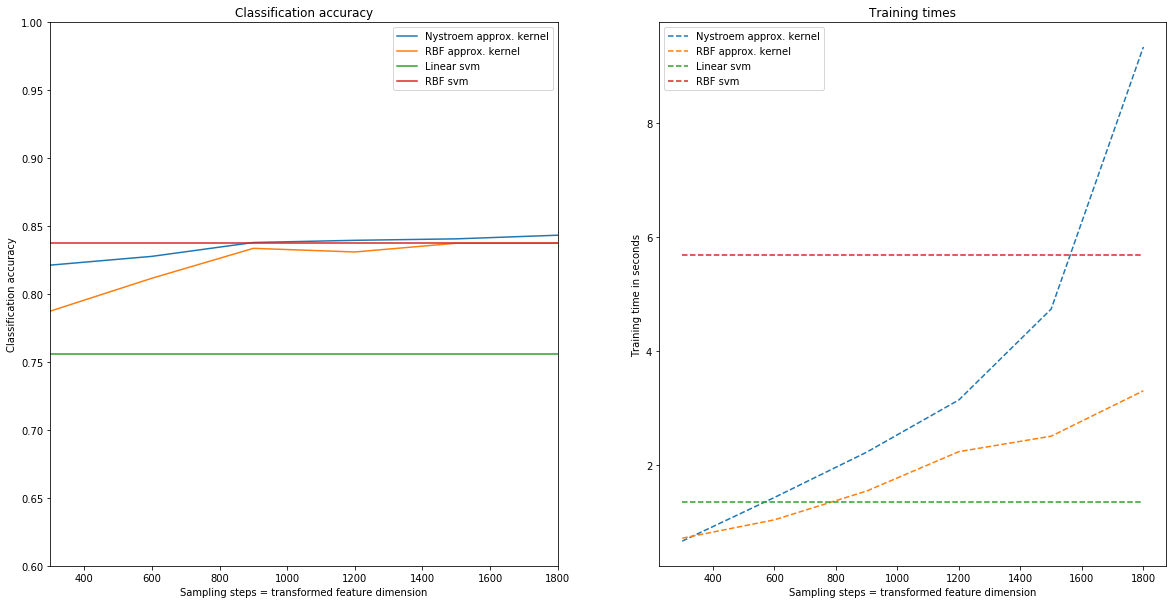

In [48]:
# plot the results:

plt.figure(figsize=(20, 10))

accuracy = plt.subplot(121)
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--', label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, rbf_scores, label="RBF approx. kernel")
timescale.plot(sample_sizes, rbf_times, '--', label='RBF approx. kernel')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="Linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='Linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="RBF svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='RBF svm')

accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")

accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_ylim(0.6, 1)

accuracy.set_xlabel("Sampling steps = transformed feature dimension")
timescale.set_xlabel("Sampling steps = transformed feature dimension")

accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")

accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show()